In [1]:
# Step 1: Import Required Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight

In [2]:
data_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Training'
val_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Validation'
classes = os.listdir(data_dir)


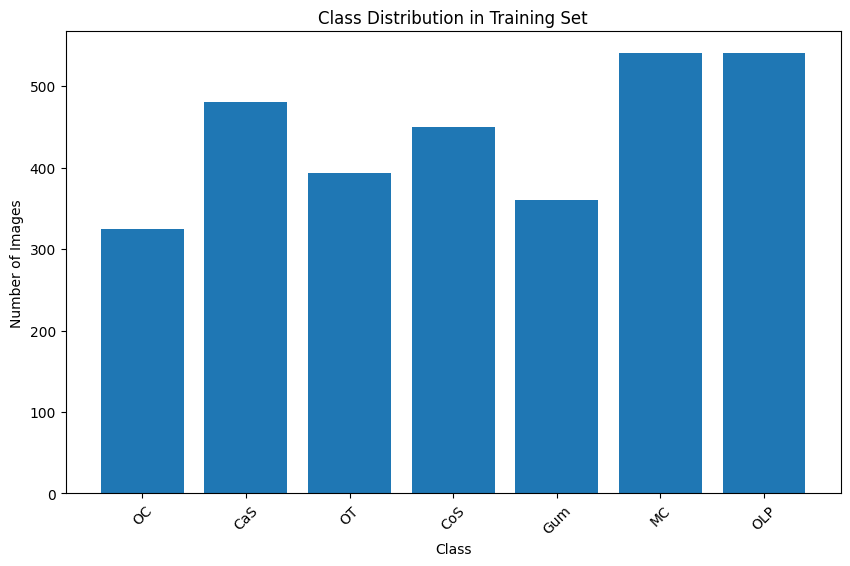

In [3]:
class_counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [16]:
# Step 3: Data Preprocessing and Augmentation
# Constants
IMG_SIZE = (256, 256)  # Resize images to 256x256
BATCH_SIZE = 32
EPOCHS = 50

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0,  # Black padding for dental images
    validation_split=0.2
)

# Validation data (only normalization)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Data generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


Found 3087 images belonging to 7 classes.


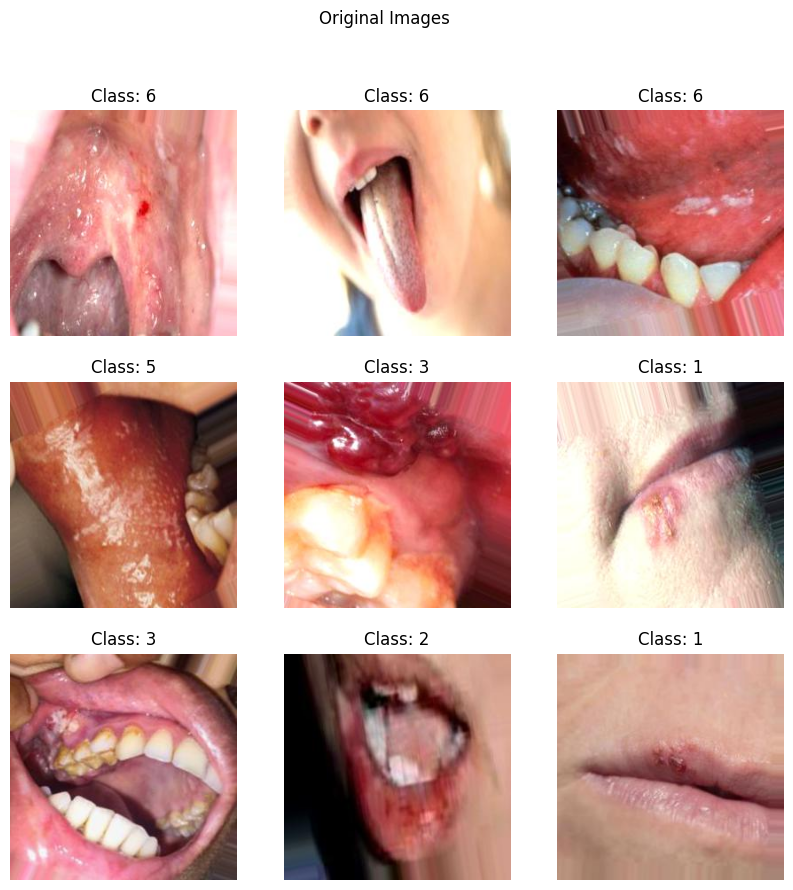

Found 3087 images belonging to 7 classes.


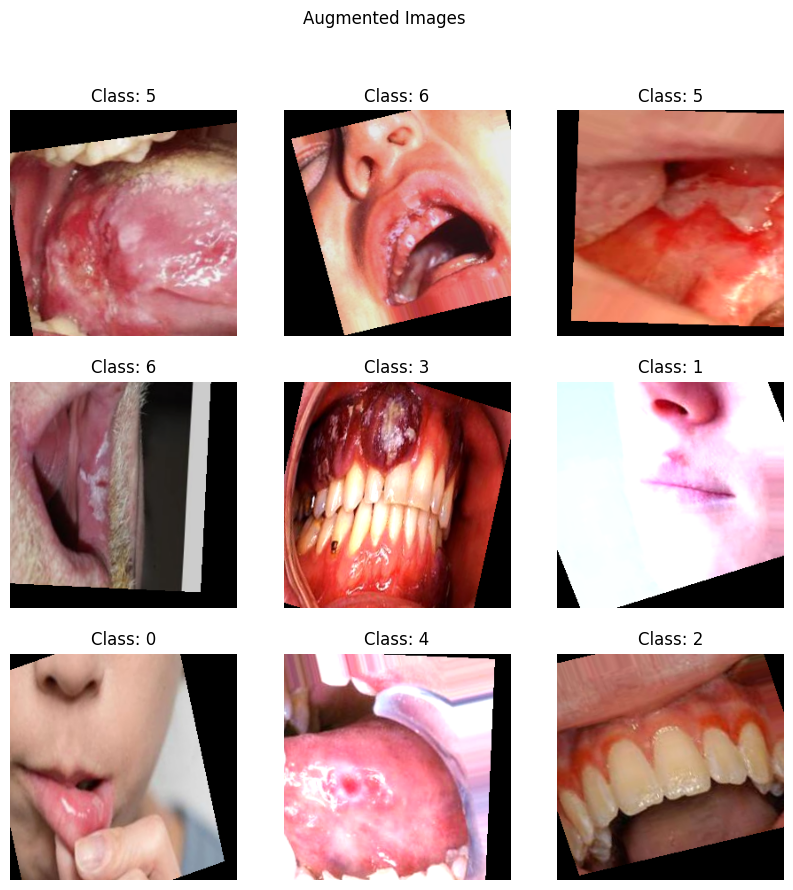

In [17]:
# Step 4: Visualize Augmented Images
def plot_augmented_images(generator, title):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize original images
original_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(data_dir, batch_size=BATCH_SIZE)
plot_augmented_images(original_generator, 'Original Images')

# Visualize augmented images
augmented_generator = train_datagen.flow_from_directory(data_dir, batch_size=BATCH_SIZE)
plot_augmented_images(augmented_generator, 'Augmented Images')

In [18]:
# Step 5: Build InceptionV3 Model from Scratch
def build_densenet_model(input_shape=(256, 256, 3), num_classes=7):
    # Use InceptionV3 architecture with pre-trained weights
    base_model = InceptionV3(
        include_top=False,
        weights='imagenet',  
        input_shape=input_shape
    )
    base_model.trainable = False
    
    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Compile the model
model = build_densenet_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 127, 127, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 127, 127, 32)   │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 127, 127, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 125, 125, 32)   │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 125, 125, 32)   │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 125, 125, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 125, 125, 64)   │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_192   │ (None, 125, 125, 64)   │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 125, 125, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 62, 62, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_193   │ (None, 62, 62, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 62, 62, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 22,863,655 (87.22 MB)

 Trainable params: 1,056,775 (4.03 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [19]:
# Step 6: Class Weight Calculation (if dataset is imbalanced)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


In [20]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weights
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 70s 563ms/step - accuracy: 0.2556 - loss: 2.4507 - val_accuracy: 0.4717 - val_loss: 1.3626
Epoch 2/50
 1/96 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5312 - loss: 1.4701

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5312 - loss: 1.4701 - val_accuracy: 0.7500 - val_loss: 0.8424
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 464ms/step - accuracy: 0.4605 - loss: 1.5742 - val_accuracy: 0.6016 - val_loss: 1.0798
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.5625 - loss: 1.0370 - val_accuracy: 1.0000 - val_loss: 0.5391
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 477ms/step - accuracy: 0.5656 - loss: 1.3013 - val_accuracy: 0.6650 - val_loss: 0.9132
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.7188 - loss: 0.8234 - val_accuracy: 0.7500 - val_loss: 0.9395
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 461ms/step - accuracy: 0.6086 - loss: 1.0957 - val_accuracy: 0.6953 - val_loss: 0.8121
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.5938 - loss: 1.2391 - val_accuracy: 1.0000 - val_loss: 0.4583
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 470ms/step - accuracy: 0.6253 - loss: 1.0638 - val_accuracy: 0.7314 - v

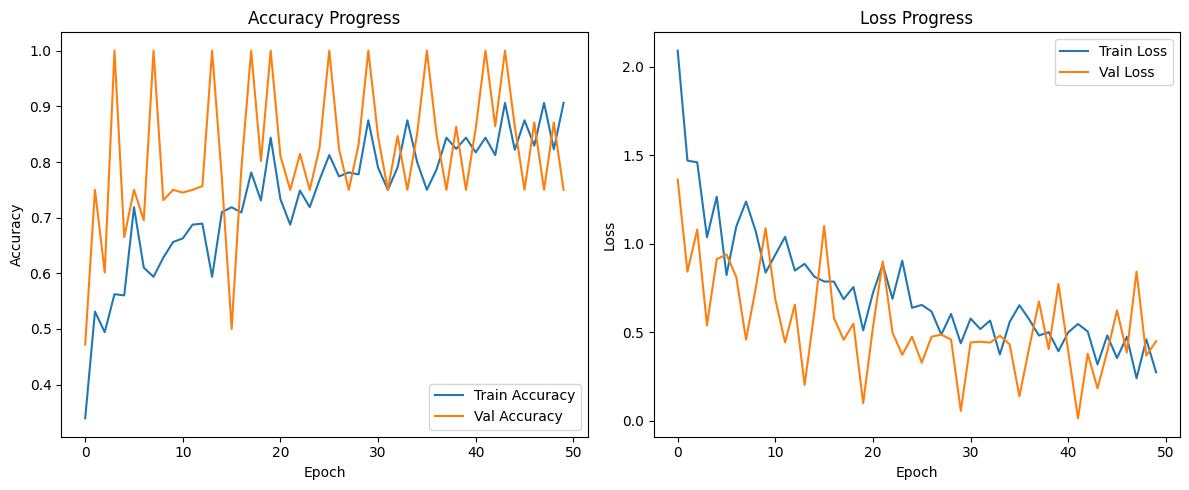

In [21]:
# Step 8: Evaluate Training Progress
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Found 1028 images belonging to 7 classes.
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9045 - loss: 0.2920

Test Accuracy: 87.74%
Test Loss: 0.3721
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step

Classification Report:
              precision    recall  f1-score   support

         CaS       0.88      0.90      0.89       160
         CoS       0.93      0.96      0.94       149
         Gum       0.86      0.94      0.90       120
          MC       0.87      0.84      0.86       180
          OC       0.79      0.94      0.86       108
         OLP       0.93      0.77      0.84       180
          OT       0.88      0.83      0.85       131

    accuracy                           0.88      1028
   macro avg       0.88      0.88      0.88      1028
weighted avg       0.88      0.88      0.88      1028



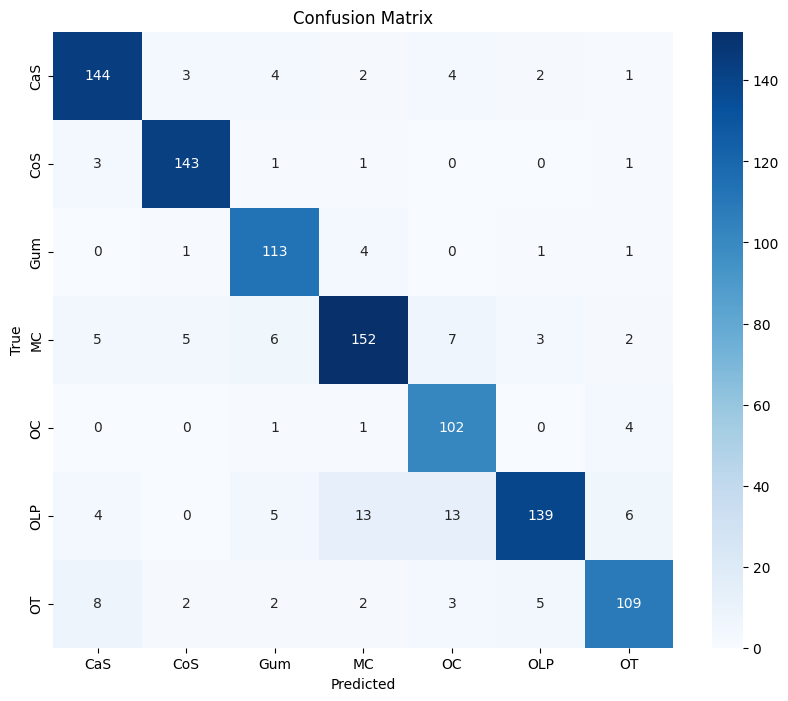

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Path to test dataset
test_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Testing'

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False ,  # Important for correct label order
    classes=["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]
)

# Evaluate model on test set
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# Visualize sample predictions
def visualize_predictions(num_samples=9):
    images, labels = next(test_generator)
    preds = model.predict(images)
    
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        true_label = class_labels[np.argmax(labels[i])]
        pred_label = class_labels[np.argmax(preds[i])]
        prob = np.max(preds[i])
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label} ({prob:.2f})", color=color)
        plt.axis('off')
    plt.savefig('/kaggle/working/sample_predictions.png')
    plt.show()


In [23]:
model.save('/kaggle/working/teeth_classification_model.h5')